
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    url = 'https://raw.githubusercontent.com/doinalangille/DS-Unit-2-Applied-Modeling/master/data/online_shoppers_intention.csv'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [0]:
# Work from previous assignments
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read data
df = pd.read_csv(url)

# Delete outliers - the last 1%
cols = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues']

for c in cols:
  if (c=='ProductRelated_Duration'):
    condition = df[c] <= (max(df[c]) - max(df[c])*0.35)
    df = df[condition]
  else:
    condition = df[c] <= (max(df[c]) - max(df[c])*0.01)
    df = df[condition]

# Use random split, because data is provided for just one year, and it is possible to lose valuable insights if splitting by month
# Split dataframe into train & test
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Revenue'], random_state=42)
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Revenue'], random_state=42)

# Define a function to wrangle the data sets in the same way

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # The dataset contains 125 duplicate rows
    # Keep only one unique row
    X.drop_duplicates(keep='first', inplace=True)

    # Convert Boolean variables into dummy variables with 1 and 0
    # 1 == True, 0 == False
    X['Revenue'] = X['Revenue'].astype(int)
    X['Weekend'] = X['Weekend'].astype(int)

    # Make a new feature to group all the scores based on either it was or not close to a holiday
    X['HolidayPeriod'] = np.where(X['SpecialDay']==0, 0, 1)

    # Some variables have to be categorical, not numerical
    # Transform them into strings
    cols_to_string = ['SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
    for c in cols_to_string:
      X[c] = X[c].astype(str)

    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

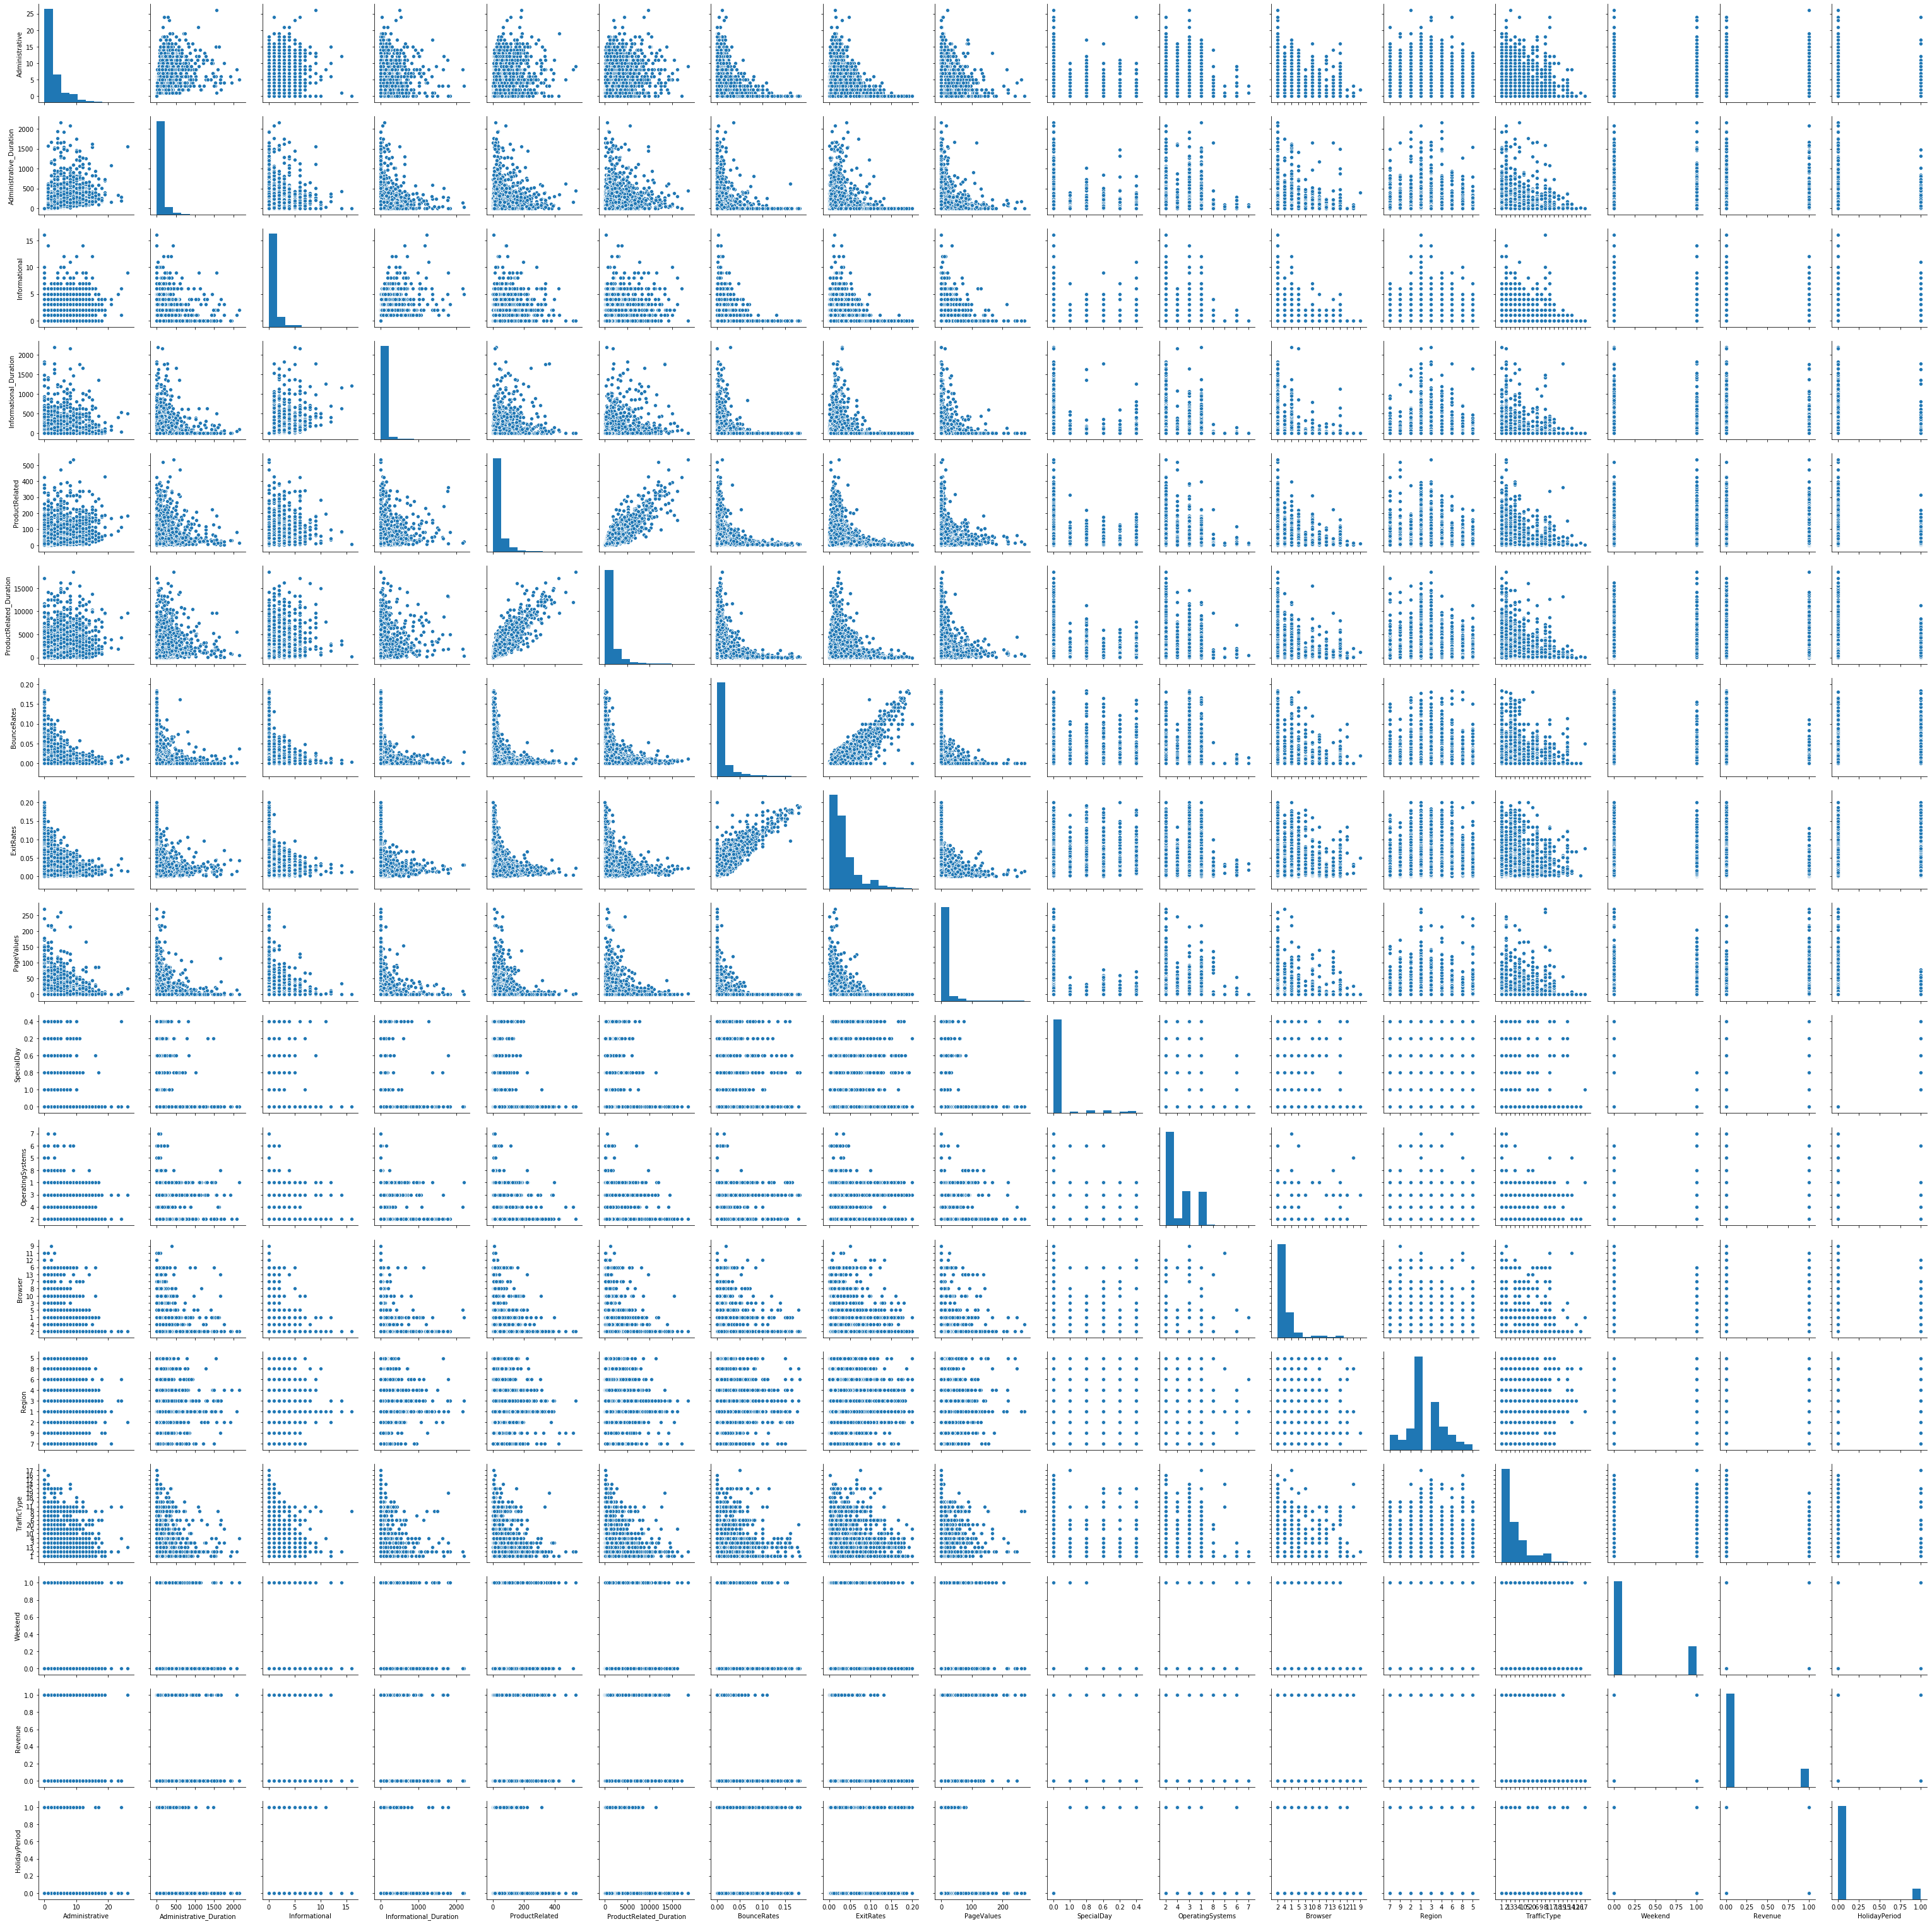

In [6]:
# Display the relationship between numerical variables
import seaborn as sns
sns.pairplot(train);

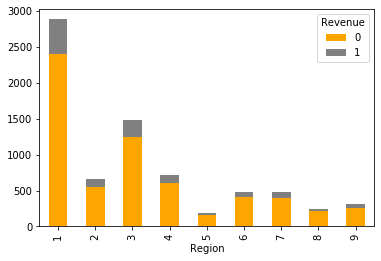

In [7]:
# Display the relationship between Region and the target
results = pd.crosstab(train['Region'], train["Revenue"])
results.plot(kind='bar', stacked=True, color=['orange', 'gray']);

In [8]:
# The model
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform

# Arrange data into X features matrix and y target vector
target = 'Revenue'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

# Make pipelines
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='precision', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


In [11]:
print('Best hyperparameters', search.best_params_)

Best hyperparameters {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.28503815231426943, 'randomforestclassifier__n_estimators': 296}


In [10]:
from sklearn.metrics import classification_report

# Make predictions for validation set
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_val)

# Get precision and recall
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1555
           1       0.81      0.48      0.61       304

    accuracy                           0.90      1859
   macro avg       0.86      0.73      0.77      1859
weighted avg       0.89      0.90      0.89      1859



### Partial Dependence Plot

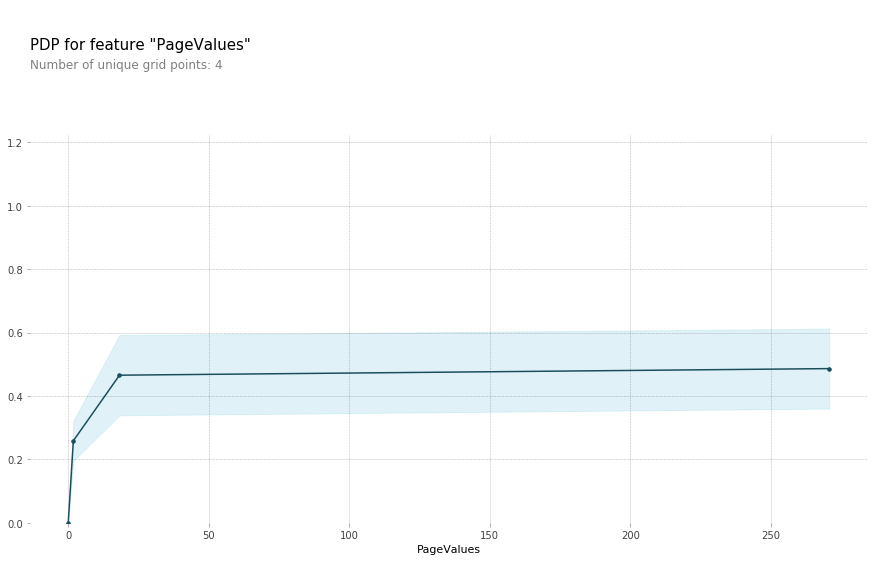

In [23]:
import matplotlib.pyplot as plt
from pdpbox import pdp
#Run the model
features = train.columns.drop(target)
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
model = RandomForestClassifier(n_estimators=296, max_features=0.2850381523142694, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)

# Plot the partial dependence
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=features, feature='PageValues')
pdp.pdp_plot(pdp_dist, 'PageValues');


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


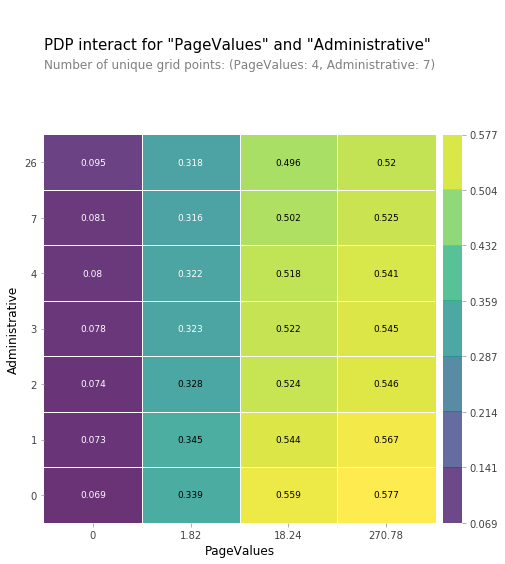

In [26]:
# Partial interaction for Page Values and Adminitrative
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['PageValues', 'Administrative']

interaction = pdp_interact(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shapley force plot